In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
keras = tf.keras

# Monte Carlo Dropout

Based on ***Dropout as a Bayesian Approximation:Representing Model Uncertainty in Deep Learning*** (2015) by Y. Gal and Z. Ghahramani (https://arxiv.org/pdf/1506.02142.pdf)

## Data

In [2]:
# Create data
X = np.arange(0, 1000, .5)
y = X**2 + np.random.randn(X.shape[0]) * .1 * (1 + X)**2

In [3]:
X.shape, y.shape

((2000,), (2000,))

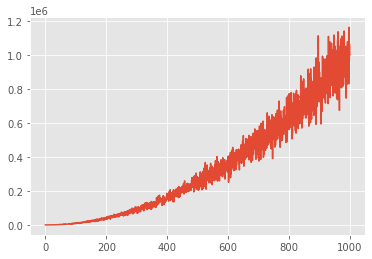

In [4]:
plt.plot(X, y)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [6]:
# Scale X
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train.reshape(-1, 1))
X_test = scaler.transform(X_test.reshape(-1, 1))

## Model

In [7]:
# Define the model
model = keras.Sequential([
    keras.layers.Dense(64, input_shape=(1,), activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dropout(.2),
    keras.layers.Dense(128, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dropout(.2),
    keras.layers.Dense(64, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dropout(.2),
    keras.layers.Dense(16, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(1),    
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                128       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1

In [9]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [10]:
history = model.fit(X_train, y_train, 
                    epochs=300,
                    validation_data=(X_test, y_test), 
                    verbose=0)

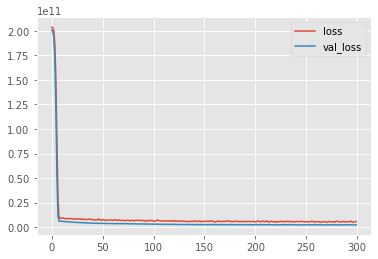

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Predict

### Point prediction

In [12]:
preds = model.predict(X_test)

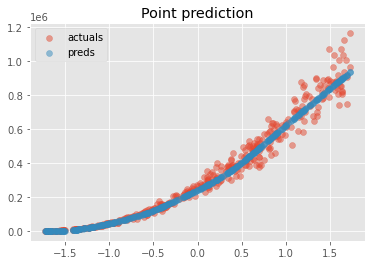

In [13]:
plt.scatter(X_test, y_test, label='actuals', alpha=.5)
plt.scatter(X_test, preds, label='preds', alpha=.5)
plt.legend()
plt.title('Point prediction')
plt.show()

### MC droupout prediction 

In [14]:
# Set n MC samples
N_SAMPLES = 1000

# predict
mc_preds_ = np.stack([model(X_test, training=True) for i in range(N_SAMPLES)])
mc_preds = mc_preds_.mean(axis=0)

In [15]:
mc_preds_.shape

(1000, 400, 1)

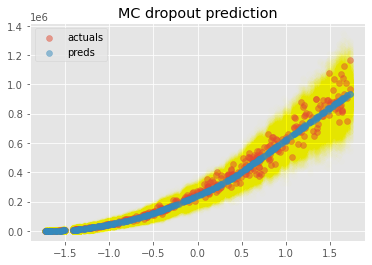

In [16]:
# Plot MC samples in yellow
for sample in mc_preds_:
    plt.scatter(X_test, sample, alpha=.01, color='yellow')
    
# Plot actuals
plt.scatter(X_test, y_test, label='actuals', alpha=.5)

# Plot mean of MC samples
plt.scatter(X_test, mc_preds, label='preds', alpha=.5)
plt.legend()
plt.title('MC dropout prediction')
plt.show()